In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
from sklearn.model_selection import train_test_split

In [3]:
APP_PATH = os.getcwd()
print(APP_PATH)
current_path = os.path.join(APP_PATH, os.path.join("data", "dataset.npz"))
train_path = APP_PATH #os.path.join(APP_PATH, os.path.join("decalearn\\task3", "dataset.npz"))
print(current_path)


c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task3
c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task3\data\dataset.npz


In [4]:
# Carrega a base de dados a partir de seu caminho
data = np.load(current_path)

X = data['X_train']
#X = X.reshape(-1,224,224,3) #reorganiza o array em um array 1 x 224 x 224 x 3

y = data['y_train']
#y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1

unseen_data = data['X_test']
#print('features: ', unseen_data.shape)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Normalize the images to a pixel value range of 0 to 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)

In [5]:
# CIFAR-10 class names
class_names = ['granite', 'basalt', 'limestone', 'sandstone', 'slate']

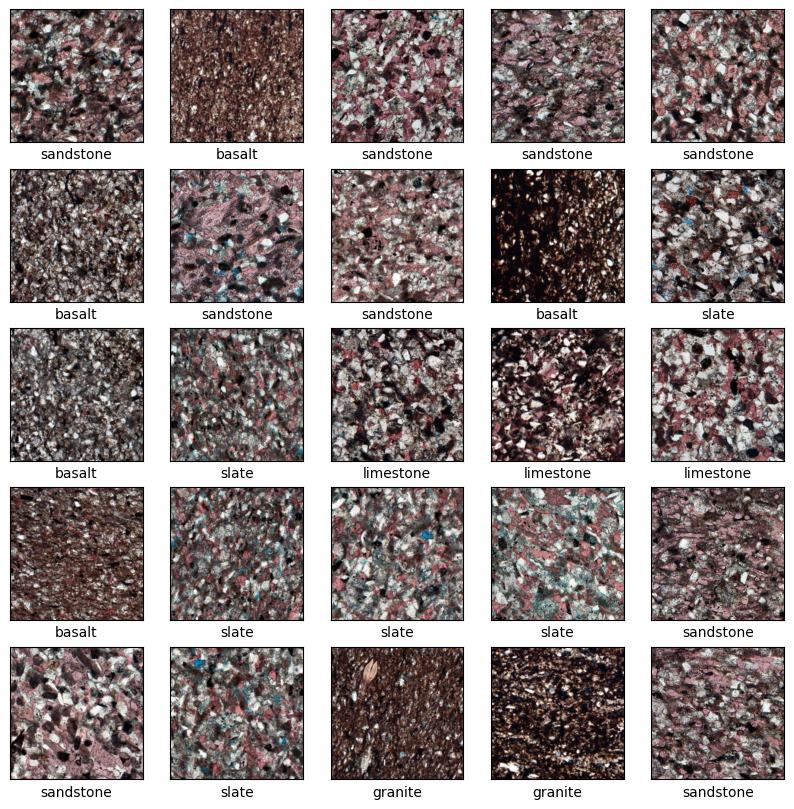

In [6]:
def plot_training_images(x_train, y_train, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(x_train.shape[0]), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[idx])
        plt.xlabel(class_names[np.argmax(y_train[idx])])
    plt.show()

# Plot some training images
plot_training_images(x_train, y_train, class_names)

In [7]:

from keras_tuner import HyperModel
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Conv2D #, MaxPooling2D, Flatten # type: ignore
from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
from tensorflow.keras.metrics import CategoricalAccuracy # type: ignore
from keras_tuner import HyperModel, BayesianOptimization

class SimpleHyperModel(HyperModel):

    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

    def build(self, hp):
        initializer = tf.keras.initializers.GlorotNormal(seed=12227)

        inputs = Input(shape=self.input_shape)

        # First Conv Layer
        H = Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation=hp.Choice('activation_1', values=['relu', 'swish']),
            kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        )(inputs)
        H = MaxPooling2D(pool_size=(2, 2))(H)
        H = BatchNormalization()(H)
        H = Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1))(H)

        # Second Conv Layer
        H = Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation=hp.Choice('activation_2', values=['relu', 'swish']),
            kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_2', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        )(H)
        H = MaxPooling2D(pool_size=(2, 2))(H)
        H = BatchNormalization()(H)
        H = Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.4, step=0.1))(H)

        H = Flatten()(H)

        # Fully Connected Layer
        H = Dense(
            units=hp.Int('units_fc_1', min_value=64, max_value=512, step=64),
            activation=hp.Choice('activation_fc_1', values=['relu', 'swish']),
            kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_fc_1', min_value=1e-5, max_value=1e-3, sampling='LOG'))
        )(H)
        H = BatchNormalization()(H)
        H = Dropout(rate=hp.Float('dropout_fc_1', min_value=0.1, max_value=0.4, step=0.1))(H)

        outputs = Dense(self.num_classes, activation='softmax', kernel_initializer=initializer)(H)
        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
        )
        
        return model
    
class HyperModel_task3(HyperModel):
    
    def __init__(self, num_classes, input_shape):
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape
        
    def build(self, hp):
        initializer = tf.keras.initializers.GlorotNormal(seed=12227)

        inputs = Input(shape=self.input_shape)

        # First Conv Layer
        H = Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation=hp.Choice('activation_1', values=['relu', 'swish']),
            kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_1', min_value=1e-5, max_value=1e-2, sampling='LOG'))
        )(inputs)
        H = MaxPooling2D(pool_size=(2, 2))(H)
        H = BatchNormalization()(H)
        H = Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1))(H)

        # Additional Conv Layers
        for i in range(hp.Int('num_conv_layers', 1, 5)):
            H = Conv2D(
                filters=hp.Int(f'filters_{i+2}', min_value=32, max_value=256, step=32),
                kernel_size=hp.Choice(f'kernel_size_{i+2}', values=[3, 5]),
                activation=hp.Choice(f'activation_{i+2}', values=['relu', 'swish']),
                kernel_initializer=initializer,
                kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_{i+2}', min_value=1e-5, max_value=1e-2, sampling='LOG'))
            )(H)
            H = MaxPooling2D(pool_size=(2, 2))(H)
            H = BatchNormalization()(H)
            H = Dropout(rate=hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1))(H)

        H = Flatten()(H)

        # Fully Connected Layers
        for i in range(hp.Int('num_fc_layers', 1, 3)):
            H = Dense(
                units=hp.Int(f'units_fc_{i+1}', min_value=64, max_value=1024, step=64),
                activation=hp.Choice(f'activation_fc_{i+1}', values=['relu', 'swish']),
                kernel_initializer=initializer,
                kernel_regularizer=tf.keras.regularizers.l2(hp.Float(f'l2_fc_{i+1}', min_value=1e-5, max_value=1e-2, sampling='LOG'))
            )(H)
            H = BatchNormalization()(H)
            H = Dropout(rate=hp.Float(f'dropout_fc_{i+1}', min_value=0.1, max_value=0.5, step=0.1))(H)

        outputs = Dense(self.num_classes, activation='softmax', kernel_initializer=initializer)(H)
        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam']),
            loss=CategoricalCrossentropy(),
            metrics=[CategoricalAccuracy()]
        )
        
        return model

In [8]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

In [9]:
num_classes=5
input_shape=(X.shape[1], X.shape[2],X.shape[3])
#hypermodel = HyperModel_task3(num_classes=num_classes, input_shape=input_shape)
hypermodel = SimpleHyperModel(num_classes=num_classes, input_shape=input_shape)

print(input_shape)

(224, 224, 3)


In [10]:
# Instantiate the tuner
tuner = BayesianOptimization(
    hypermodel,
    objective='val_categorical_accuracy',
    max_trials=30,
    executions_per_trial=3,
    directory=train_path,
    project_name='hyperparam_tuning_image',
    #overwrite=True  # Overwrite the previous results if needed
)

Reloading Tuner from c:\Caio\DevProjects\Python\academico\doutorado\disciplinas\PCS5022 - Redes Neurais\decalearn\task3\hyperparam_tuning_image\tuner0.json


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [12]:
tuner.search(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    batch_size=16,
    #multi_worker_mirrored_strategy=True,
    #workers=num_cpus,
    verbose=2
)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |128               |filters_1
3                 |3                 |kernel_size_1
relu              |swish             |activation_1
0.00033908        |1.2459e-05        |l2_1
0.2               |0.4               |dropout_1
32                |96                |filters_2
3                 |3                 |kernel_size_2
relu              |swish             |activation_2
0.00019779        |3.6181e-05        |l2_2
0.2               |0.2               |dropout_2
384               |192               |units_fc_1
swish             |swish             |activation_fc_1
0.00025069        |0.00027377        |l2_fc_1
0.3               |0.4               |dropout_fc_1
sgd               |adam              |optimizer


Epoch 1/30


c:\Users\cazev\miniconda3\envs\webapp\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 - 239s - 2s/step - categorical_accuracy: 0.7188 - loss: 1.0308 - val_categorical_accuracy: 0.2555 - val_loss: 10.4256 - learning_rate: 0.0100
Epoch 2/30
114/114 - 231s - 2s/step - categorical_accuracy: 0.8117 - loss: 0.7307 - val_categorical_accuracy: 0.2555 - val_loss: 17.1160 - learning_rate: 0.0100
Epoch 3/30
114/114 - 231s - 2s/step - categorical_accuracy: 0.8380 - loss: 0.6381 - val_categorical_accuracy: 0.3794 - val_loss: 12.2263 - learning_rate: 0.0100
Epoch 4/30
114/114 - 244s - 2s/step - categorical_accuracy: 0.8646 - loss: 0.5641 - val_categorical_accuracy: 0.2566 - val_loss: 12.0178 - learning_rate: 0.0100
Epoch 5/30
114/114 - 225s - 2s/step - categorical_accuracy: 0.8775 - loss: 0.5113 - val_categorical_accuracy: 0.5362 - val_loss: 4.9664 - learning_rate: 0.0020
Epoch 6/30
114/114 - 225s - 2s/step - categorical_accuracy: 0.8871 - loss: 0.4897 - val_categorical_accuracy: 0.6140 - val_loss: 2.6500 - learning_rate: 0.0020
Epoch 7/30
114/114 - 255s - 2s/step - categoric

KeyboardInterrupt: 

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
batch_size = 64
epochs = 30

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=x_train.shape[0] // batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[early_stopping, reduce_lr],
          )

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.5823 - loss: 0.9165 - val_accuracy: 0.4046 - val_loss: 1.3655 - learning_rate: 2.0000e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4046 - val_loss: 1.3655 - learning_rate: 2.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 245s 4s/step - accuracy: 0.6238 - loss: 0.8505 - val_accuracy: 0.4211 - val_loss: 1.3593 - learning_rate: 2.0000e-04
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4211 - val_loss: 1.3593 - learning_rate: 2.0000e-04
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.6252 - loss: 0.8576 - val_accuracy: 0.3783 - val_loss: 1.5197 - learning_rate: 2.0000e-04


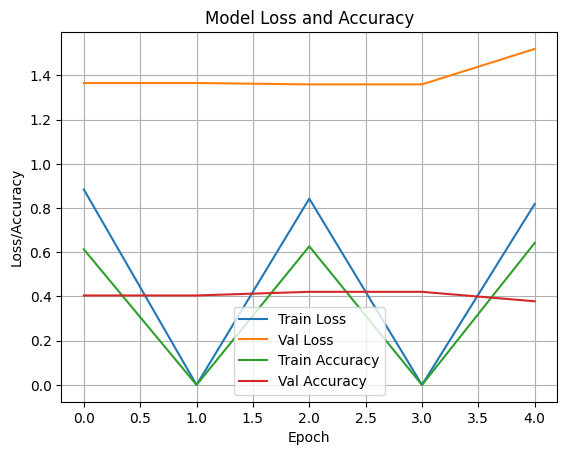

In [23]:
# Plot the training and validation loss/accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

29/29 - 11s - 370ms/step - accuracy: 0.8980 - loss: 0.2623
Test accuracy: 89.80%


In [25]:
new_images = unseen_data.astype('float32') / 255.0

In [1]:
# Make predictions on the new dataset
predictions = model.predict(new_images)

# Get the class with the highest probability for each image
predicted_classes = np.argmax(predictions, axis=1)

NameError: name 'model' is not defined

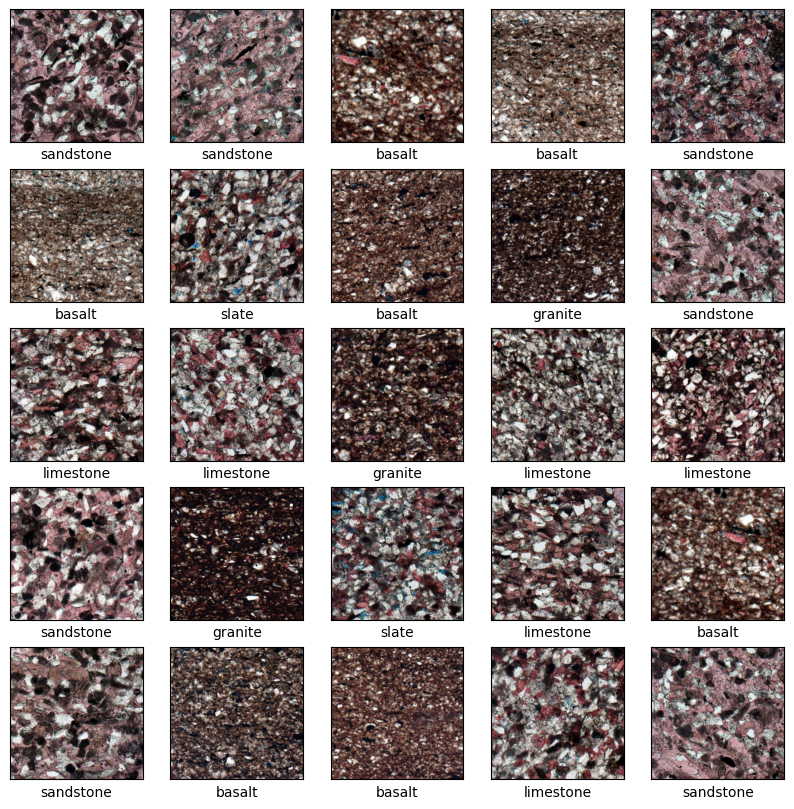

In [ ]:
def plot_new_predictions(new_images, predicted_classes, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(range(new_images.shape[0]), num_images, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(new_images[idx])
        plt.xlabel(class_names[predicted_classes[idx]])
    plt.show()

# Plot some new images with predicted labels
plot_new_predictions(new_images, predicted_classes, class_names)

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(range(1, len(predicted_classes) + 1), predicted_classes)), columns=['ID', 'Prediction'])
    #df = pd.DataFrame({'ID': np.arange(1, num_samples + 1),'Prediction': predictions})
df.to_csv(submission_file, index=False)